In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

In [5]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [40]:
import requests
import json
import datetime as dt

api_key = 'K9OPGNS5IDET8VU5'  # replace with your own API key from Alpha Vantage
company = 'AAPL'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2023, 1, 1)

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={company}&outputsize=full&apikey={api_key}'

response = requests.get(url)

close_prices = []

if response.status_code != 200:
    print('Error: Could not retrieve data from Alpha Vantage API')
else:
    data = response.json()['Time Series (Daily)']
    for date, values in data.items():
        date_obj = dt.datetime.strptime(date, '%Y-%m-%d')
        if start <= date_obj <= end:
            close_prices.append(float(values['4. close']))
            print(date, values['4. close'])


2022-12-30 129.93
2022-12-29 129.61
2022-12-28 126.04
2022-12-27 130.03
2022-12-23 131.86
2022-12-22 132.23
2022-12-21 135.45
2022-12-20 132.3
2022-12-19 132.37
2022-12-16 134.51
2022-12-15 136.5
2022-12-14 143.21
2022-12-13 145.47
2022-12-12 144.49
2022-12-09 142.16
2022-12-08 142.65
2022-12-07 140.94
2022-12-06 142.91
2022-12-05 146.63
2022-12-02 147.81
2022-12-01 148.31
2022-11-30 148.03
2022-11-29 141.17
2022-11-28 144.22
2022-11-25 148.11
2022-11-23 151.07
2022-11-22 150.18
2022-11-21 148.01
2022-11-18 151.29
2022-11-17 150.72
2022-11-16 148.79
2022-11-15 150.04
2022-11-14 148.28
2022-11-11 149.7
2022-11-10 146.87
2022-11-09 134.87
2022-11-08 139.5
2022-11-07 138.92
2022-11-04 138.38
2022-11-03 138.88
2022-11-02 145.03
2022-11-01 150.65
2022-10-31 153.34
2022-10-28 155.74
2022-10-27 144.8
2022-10-26 149.35
2022-10-25 152.34
2022-10-24 149.45
2022-10-21 147.27
2022-10-20 143.39
2022-10-19 143.86
2022-10-18 143.75
2022-10-17 142.41
2022-10-14 138.38
2022-10-13 142.99
2022-10-12 138.

In [41]:
# prepare data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array([float(values['4. close']) for values in data.values()]).reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [43]:
# building the model
model = Sequential()
model.add(LSTM(units=50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # prediction of the next close price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train, epochs=8, batch_size=32)

Epoch 1/8
184/184 [==============================] - 21s 83ms/step - loss: 0.0057
Epoch 2/8
184/184 [==============================] - 16s 84ms/step - loss: 0.0022
Epoch 3/8
184/184 [==============================] - 15s 83ms/step - loss: 0.0019
Epoch 4/8
184/184 [==============================] - 16s 85ms/step - loss: 0.0018
Epoch 5/8
184/184 [==============================] - 15s 83ms/step - loss: 0.0017
Epoch 6/8
184/184 [==============================] - 16s 85ms/step - loss: 0.0014
Epoch 7/8
184/184 [==============================] - 16s 84ms/step - loss: 0.0012
Epoch 8/8
184/184 [==============================] - 16s 86ms/step - loss: 0.0012


In [49]:
# load test data

api_key = 'K9OPGNS5IDET8VU5'  # replace with your own API key from Alpha Vantage
company = 'AAPL'
test_start = dt.datetime(2023, 1, 1)
test_end = dt.datetime.now()

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={company}&outputsize=full&apikey={api_key}'

response = requests.get(url)


if response.status_code != 200:
    print('Error: Could not retrieve data from Alpha Vantage API')
else:
    test_data = response.json()['Time Series (Daily)']
    actual_close_prices = []
    for date, values in test_data.items():
        date_obj = dt.datetime.strptime(date, '%Y-%m-%d')
        if test_start <= date_obj <= test_end:
            actual_close_prices.append(float(values['4. close']))
            print(date, values['4. close'])

total_dataset = pd.concat((pd.Series(close_prices), pd.Series(actual_prices)), axis=0)

models_inputs = total_dataset[len(total_dataset) - len(actual_prices) - prediction_days:].values
models_inputs = models_inputs.reshape(-1, 1)
models_inputs = scaler.transform(models_inputs)


2023-06-16 184.92
2023-06-15 186.01
2023-06-14 183.95
2023-06-13 183.31
2023-06-12 183.79
2023-06-09 180.96
2023-06-08 180.57
2023-06-07 177.82
2023-06-06 179.21
2023-06-05 179.58
2023-06-02 180.95
2023-06-01 180.09
2023-05-31 177.25
2023-05-30 177.3
2023-05-26 175.43
2023-05-25 172.99
2023-05-24 171.84
2023-05-23 171.56
2023-05-22 174.2
2023-05-19 175.16
2023-05-18 175.05
2023-05-17 172.69
2023-05-16 172.07
2023-05-15 172.07
2023-05-12 172.57
2023-05-11 173.75
2023-05-10 173.555
2023-05-09 171.77
2023-05-08 173.5
2023-05-05 173.57
2023-05-04 165.79
2023-05-03 167.45
2023-05-02 168.54
2023-05-01 169.59
2023-04-28 169.68
2023-04-27 168.41
2023-04-26 163.76
2023-04-25 163.77
2023-04-24 165.33
2023-04-21 165.02
2023-04-20 166.65
2023-04-19 167.63
2023-04-18 166.47
2023-04-17 165.23
2023-04-14 165.21
2023-04-13 165.56
2023-04-12 160.1
2023-04-11 160.8
2023-04-10 162.03
2023-04-06 164.66
2023-04-05 163.76
2023-04-04 165.63
2023-04-03 166.17
2023-03-31 164.9
2023-03-30 162.36
2023-03-29 160.

In [50]:
# Make Predictions on Test Data
x_test = []
for x in range(prediction_days, len(models_inputs)):
    x_test.append(models_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

75/75 [==============================] - 2s 26ms/step


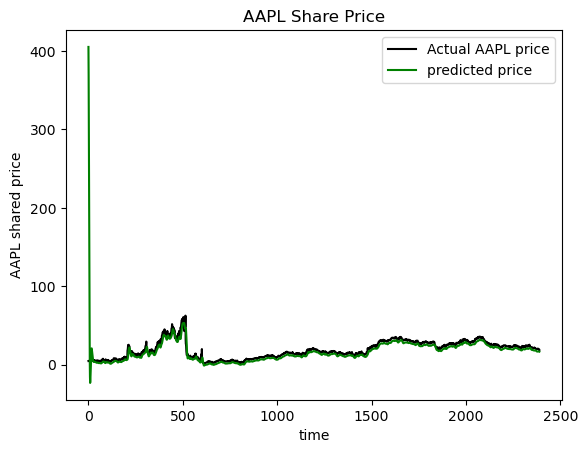

In [51]:
# plot the test predictions
plt.plot(actual_prices, color='black', label=f'Actual {company} price')
plt.plot(prediction_prices, color='green', label=f'predicted price')
plt.title(f'{company} Share Price')
plt.xlabel('time')
plt.ylabel(f'{company} shared price')
plt.legend()
plt.show()

In [52]:
# Predicting the next day

real_data = [models_inputs[len(models_inputs) + 1 - prediction_days:len(models_inputs + 7), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')

1/1 [==============================] - 0s 35ms/step
Prediction: [[16.494596]]


In [53]:
# Predicting multiple days

num_days = 7  # Number of days to predict

real_data = models_inputs[len(models_inputs) - prediction_days:len(models_inputs), 0]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (1, real_data.shape[0], 1))

predictions = []
for _ in range(num_days):
    prediction = model.predict(real_data)
    predictions.append(prediction)
    real_data = np.append(real_data[:, 1:, :], np.reshape(prediction, (1, 1, 1)), axis=1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print(f'Predictions: {predictions}')


1/1 [==============================] - 0s 29ms/step
Predictions: [[16.493668]
 [16.147697]
 [15.595514]
 [14.890583]
 [14.095071]
 [13.257578]
 [12.409074]]
